In [1]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft
import numpy as np
import re
import struct

In [2]:
def parse_wf_from_binary(filename):
    data_list = []
    nlines=0
    nevents=2000
    with open(filename, "rb") as f:
        while True:
            # Read the header
            data = f.read(4)  # Read uint32_t EVID
            if not data:
                break
            EVID = struct.unpack("<I", data)[0]
            data = f.read(8)  # Read uint64_t T
            if not data:
                break
            T = struct.unpack("<Q", data)[0]
            data = f.read(4)  # Read uint32_t size
            if not data:
                break
            size = struct.unpack("<I", data)[0]
            data = f.read(8)  # Read uint64_t sampl_time
            if not data:
                break
            sampl_time = struct.unpack("<Q", data)[0]
            data = f.read(4)  # Read uint32_t ch (number of channels)
            if not data:
                break
            ch = struct.unpack("<I", data)[0]
            waveform_data = {}
            # Read waveforms for each channel
            for channel in range(ch):
                data = f.read(2)  # Read uint16_t numch
                if not data:
                    break
                numch = struct.unpack("<H", data)[0]
                channel_waveforms = []
                for _ in range(size):
                    data = f.read(4)  # Read float w
                    if not data:
                        break
                    w = struct.unpack("<f", data)[0]
                    channel_waveforms.append(w)
                waveform_data[f'{numch}'] = channel_waveforms
            # Create a row per sample point with all channels aligned
            for i in range(size):
                row = {}
                
                row.update({f'CH{j+1}': waveform_data[f'{numch}'][i]/1e3 for j,numch in enumerate(waveform_data)})
                row.update({"event": EVID})
                row.update({"event_time": T})

                data_list.append(row)

    print(nlines,nevents)
    df = pd.DataFrame(data_list)
    df.insert(0, 'TIME', (df.index % size + 1) * sampl_time/1e9)  # Time in microseconds

    return df

In [3]:
df = parse_wf_from_binary('tempdata/Acq_dig2-192.168.0.254_20250603125359-05.bin')

0 2000


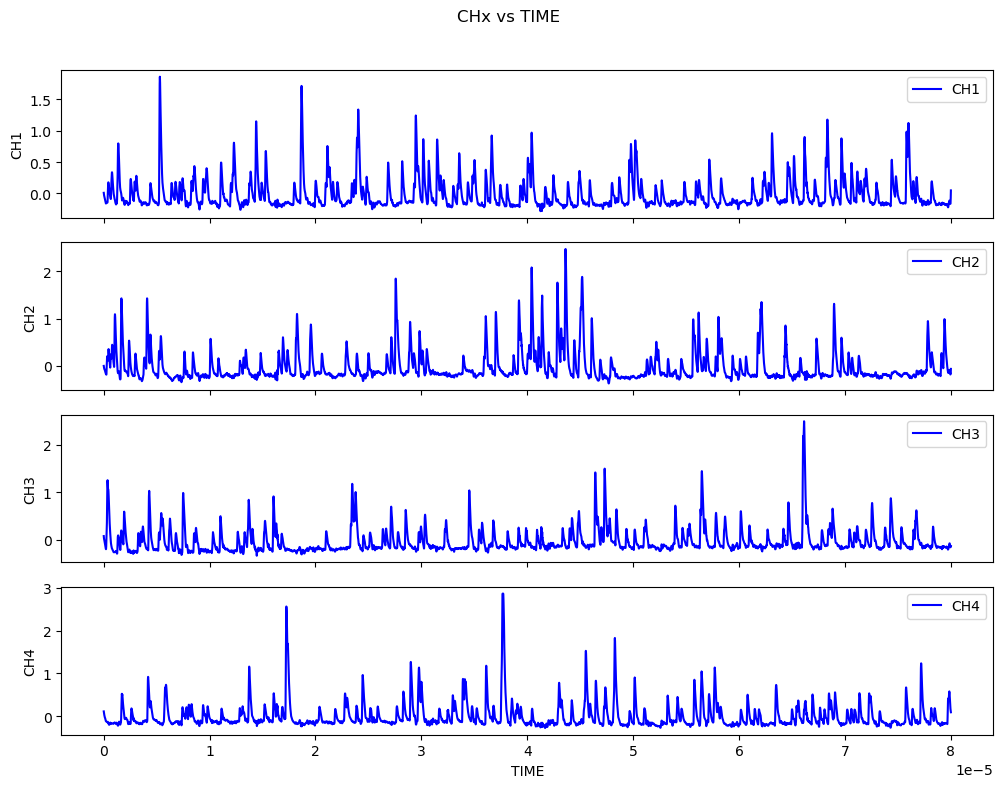

In [15]:
event_list = df['event'].unique()
an_event= 34

df_event = df[df['event']==event_list[an_event]]

for ch in ['CH1', 'CH2', 'CH3', 'CH4']:
    max_finite_value = df_event[ch][np.isfinite(df_event[ch])].max()  # Find the max finite value
    #df_event[ch].replace([np.inf, -np.inf], max_finite_value, inplace=True)  # Replace inf values
    
# Set up the subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('CHx vs TIME')

# Plot each channel in its own subplot
channels = ['CH1', 'CH2', 'CH3', 'CH4']
for i, ch in enumerate(channels):
    axs[i].plot(df_event['TIME'], df_event[ch], label=ch, color='b')
    axs[i].set_ylabel(ch)
    axs[i].legend(loc='upper right')

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('TIME')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()

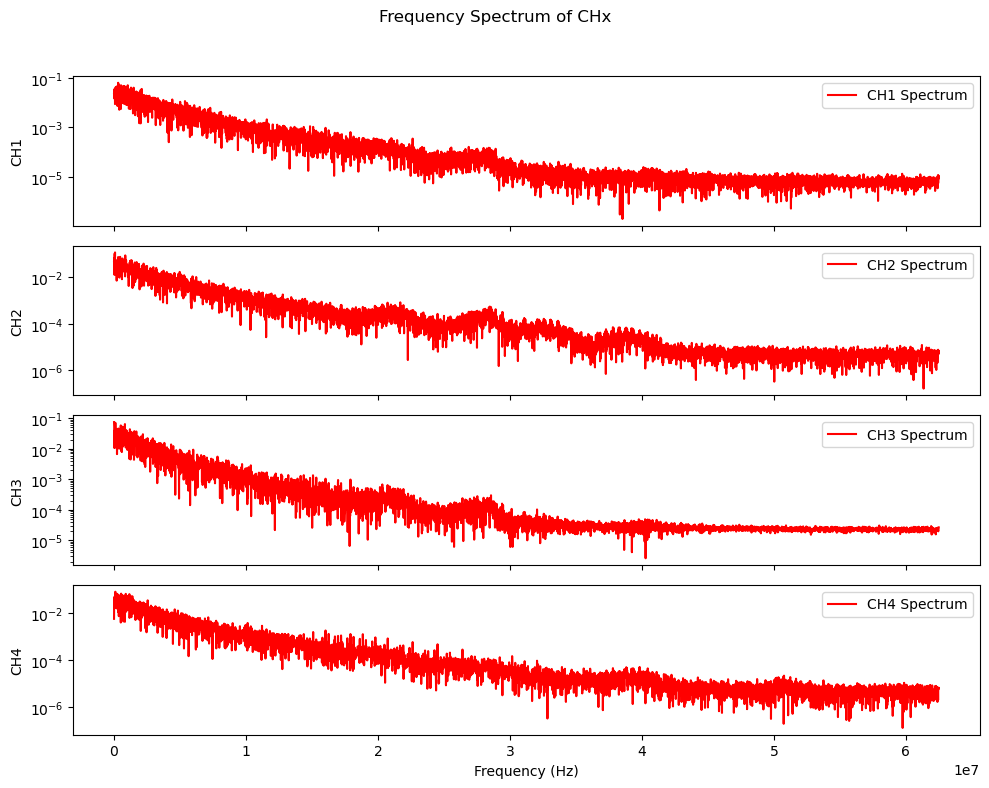

In [16]:
time = df_event['TIME'].values
sampling_interval = time[1] - time[0]
sampling_rate = 1 / sampling_interval

# Set up the subplots for frequency spectrum
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Frequency Spectrum of CHx')

# Perform FFT and plot the frequency spectrum for each channel
channels = ['CH1', 'CH2', 'CH3', 'CH4']
for i, ch in enumerate(channels):
    # Perform Fourier Transform
    signal = df_event[ch].values
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, sampling_interval)[:N//2]  # Frequencies (one side of the spectrum)

    # Plot the amplitude spectrum
    axs[i].plot(xf, 2.0/N * np.abs(yf[:N//2]), label=f'{ch} Spectrum', color='r')
    axs[i].set_ylabel(ch)
    axs[i].set_yscale('log')
    axs[i].legend(loc='upper right')

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('Frequency (Hz)')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()

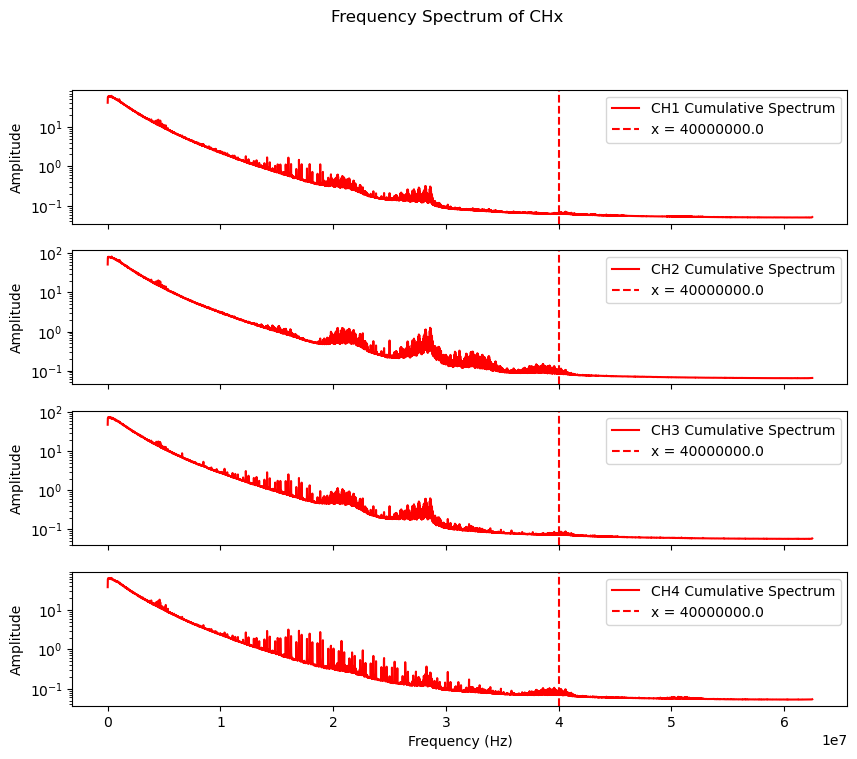

In [19]:
# Find unique events
unique_events = df['event'].unique()

# Dictionary to store the cumulative frequency spectra for each channel
cumulative_frequency_spectrum = {ch: None for ch in ['CH1', 'CH2', 'CH3', 'CH4']}
sampling_interval = df['TIME'].iloc[1] - df['TIME'].iloc[0]  # Assuming consistent sampling
N = len(df[df['event'] == unique_events[0]])  # Length of each event's data
xf = fftfreq(N, sampling_interval)[:N//2]  # Frequency bins (one side of the spectrum)

# Loop over each event and accumulate the frequency spectra
for event in unique_events:
    df_event = df[df['event'] == event]
    
    # Perform FFT for each channel and accumulate the amplitude spectra
    for ch in cumulative_frequency_spectrum.keys():
        signal = df_event[ch].values
        
        if len(signal) > 1:  # Ensure there's enough data for FFT
            yf = fft(signal)
            intensities = 2.0/N * np.abs(yf[:N//2])  # Amplitude spectrum
            
            # Accumulate the spectra
            if cumulative_frequency_spectrum[ch] is None:
                cumulative_frequency_spectrum[ch] = intensities
            else:
                if(intensities[0]!=np.inf):
                    cumulative_frequency_spectrum[ch] += intensities

            #print(event,ch,cumulative_frequency_spectrum[ch])

# Plot the cumulative frequency spectra for each channel
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Frequency Spectrum of CHx')

freq_cut = 0.4e8

channels = ['CH1', 'CH2', 'CH3', 'CH4']
for i, ch in enumerate(channels):
    axs[i].plot(xf, cumulative_frequency_spectrum[ch], label=f'{ch} Cumulative Spectrum', color='r')
    axs[i].axvline(x=freq_cut, color='r', linestyle='--', label=f'x = {freq_cut}')
    axs[i].set_ylabel('Amplitude')
    axs[i].set_yscale('log')  # Optional: log scale for intensity
    axs[i].legend(loc='upper right')

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('Frequency (Hz)')

#plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()

<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


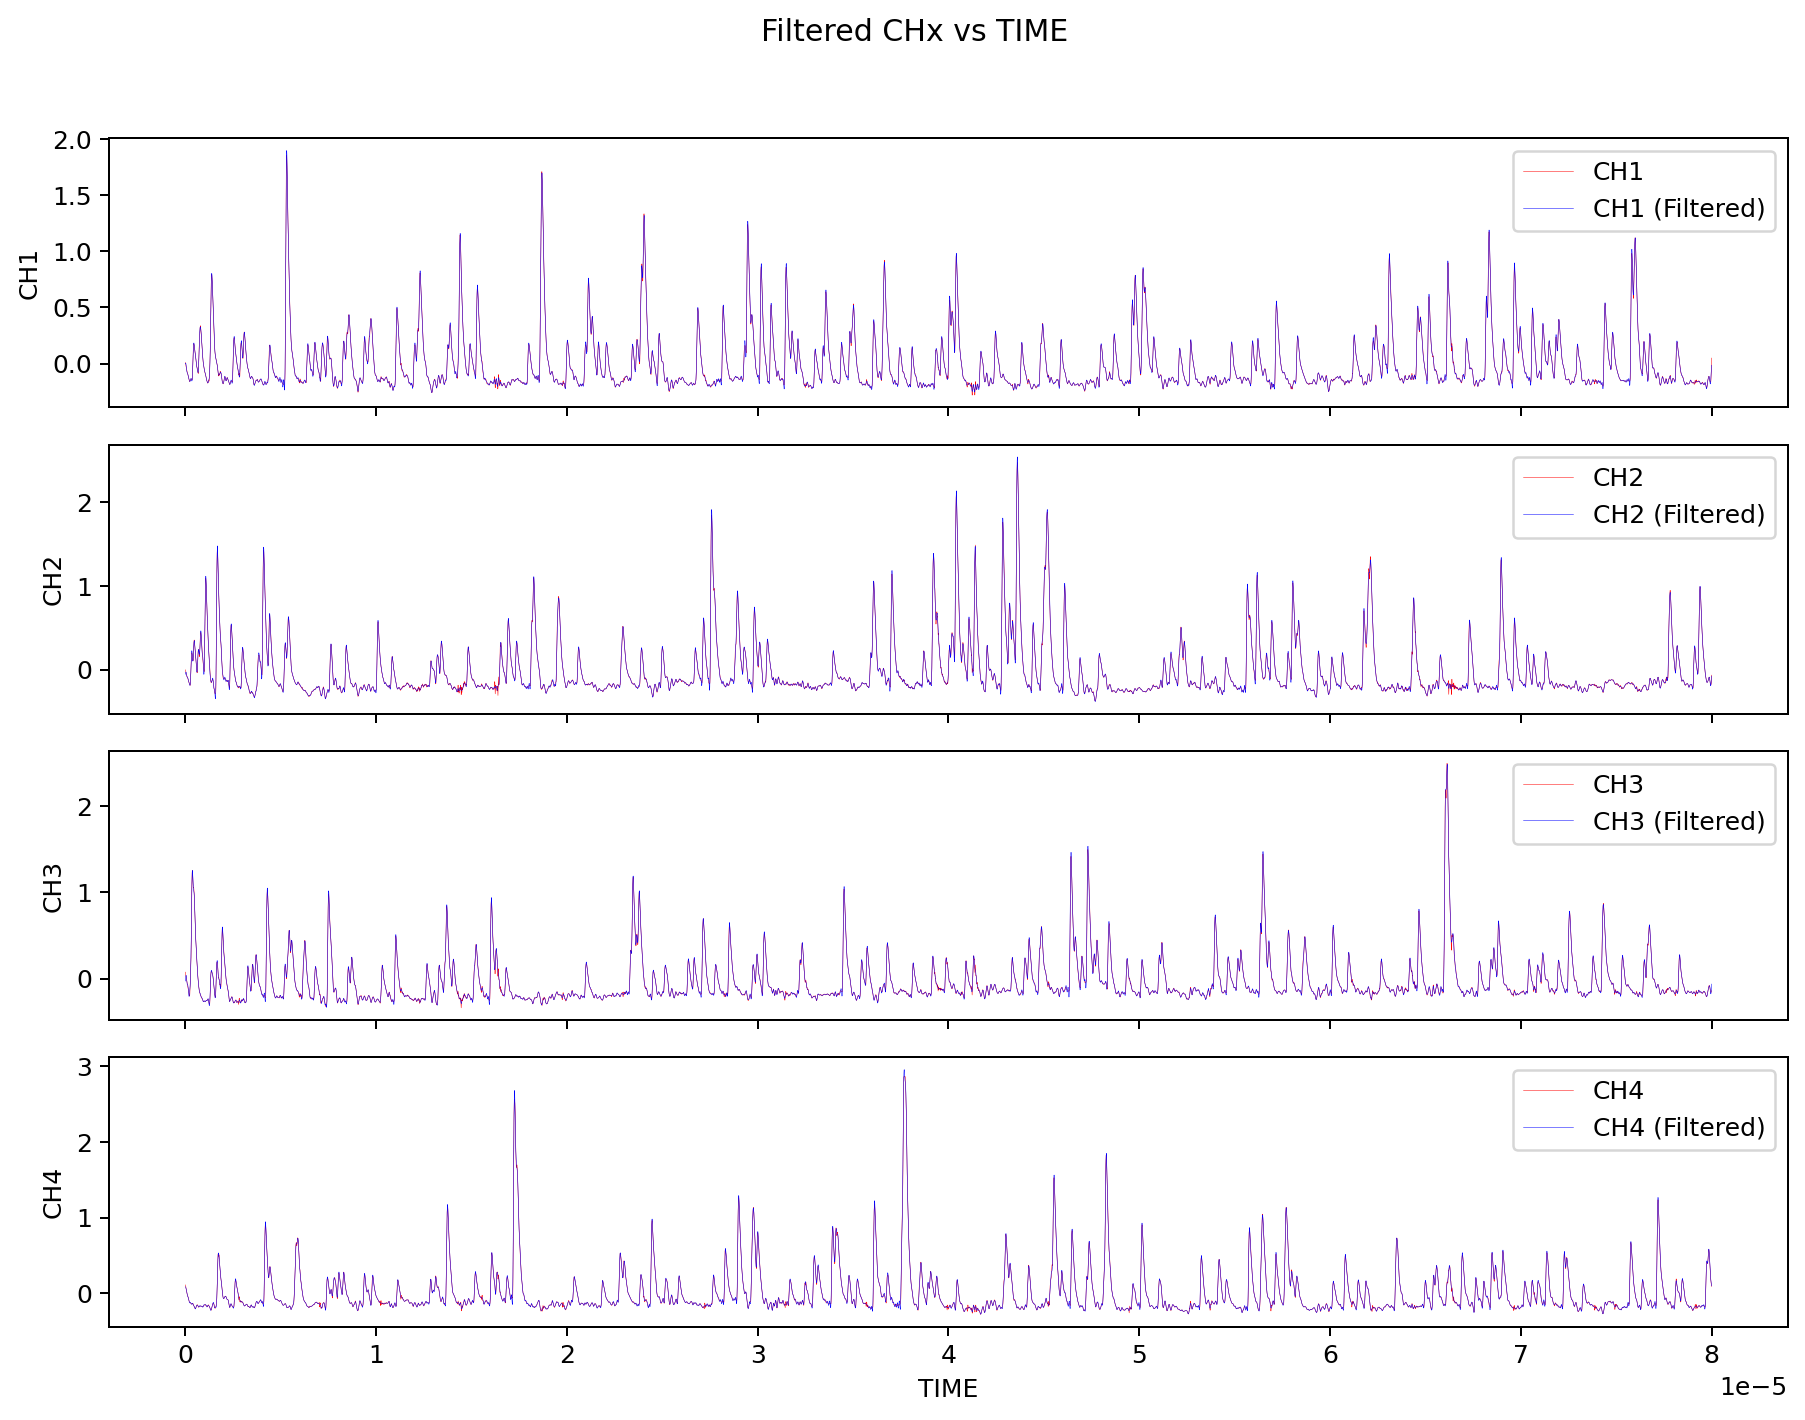

In [28]:
# Set up the cutoff frequency
cutoff_frequency = 1e7  # 5 MHz

df_event = df[df['event']==event_list[an_event]]

# Prepare subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True, dpi=180)
fig.suptitle('Filtered CHx vs TIME')

# Define the sampling parameters
time = df_event['TIME'].values
sampling_interval = time[1] - time[0]
sampling_rate = 1 / sampling_interval
N = len(time)

# Plot each filtered channel in its own subplot
channels = ['CH1', 'CH2', 'CH3', 'CH4']
for i, ch in enumerate(channels):
    # Get the original signal
    signal = df_event[ch].values
    
    # Perform Fourier Transform
    yf = fft(signal)
    xf = fftfreq(N, sampling_interval)

    # Apply the low-pass filter (zero out frequencies above cutoff)
    yf[np.abs(xf) > cutoff_frequency] = 0

    # Inverse FFT to obtain the filtered signal in time domain
    filtered_signal = ifft(yf).real

    # Plot the filtered signal
    axs[i].plot(df_event['TIME'], df_event[ch], label=ch, color='r',linewidth=.2)
    axs[i].plot(df_event['TIME'], filtered_signal, label=f'{ch} (Filtered)', color='b',linewidth=.2)
    axs[i].set_ylabel(ch)
    axs[i].legend(loc='upper right')
    print(type(df_event[ch]),type(filtered_signal))

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('TIME')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()